In [1]:
import os
import torch
from typing import List, Callable
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.transforms.functional as F
from torchvision.transforms import InterpolationMode
from torch.utils.data import TensorDataset, DataLoader
from math import factorial
from itertools import product
from tqdm import trange

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Generate basis functions b_i(x, y) = x^p y^q / r! with p+q=r <= MAX_DEGREE
def generate_homogeneous_basis(max_degree: int):
    basis = []
    degrees = []  # (r = p + q)
    for r in range(max_degree + 1):
        for p in range(r + 1):
            q = r - p
            def monomial(p=p, q=q, r=r):
                return lambda X, Y: (X**p * Y**q) / factorial(r)
            basis.append(monomial())
            degrees.append(r)
    return basis, degrees

# Compute basis vector from image phi
def compute_basis_vector(phi: torch.Tensor) -> torch.Tensor:
    width, height = phi.shape
    k = torch.arange(width, device=phi.device) - width // 2
    j = torch.arange(height, device=phi.device) - height // 2
    X, Y = torch.meshgrid(k, j, indexing="ij")
    return torch.stack([(b(X, Y) * phi).sum() for b in BASIS])

# Precompute and cache dataset
def get_or_create_augmented_tensor_dataset(train: bool = True, limit = None, overwrite_cache: bool = False) -> TensorDataset:
    split_name = "train" if train else "test"
    limit_str = f"{limit}" if limit is not None else "all"
    CACHE_DIR = f"./data"
    os.makedirs(CACHE_DIR, exist_ok=True)
    cache_path = os.path.join(CACHE_DIR, f"scaled_mnist_limit{limit_str}_{split_name}_BaseDegree{MAX_DEGREE}.pt")

    if os.path.exists(cache_path) and not overwrite_cache:
        print(f"Loading cached dataset from: {cache_path}")
        dataset = torch.load(cache_path, weights_only=False)
        return TensorDataset(dataset.tensors[0].to(device), dataset.tensors[1].to(device))

    print(f"Creating augmented dataset for MNIST ({split_name})...")
    mnist_ds = MNIST(root="./data", train=train, download=True, transform=transforms.ToTensor())

    X_list, y_list = [], []

    num_samples = len(mnist_ds) if limit is None else min(limit, len(mnist_ds))
    total_iterations = num_samples * len(SCALES) * len(ANGLES)

    with trange(num_samples, desc=f"Augmenting {split_name}") as t:
        for idx in t:

            tensor_img, label = mnist_ds[idx]

            for scale in SCALES:
                for angle in ANGLES:
                    transformed = F.affine(
                        tensor_img,
                        angle=angle,
                        translate=(0, 0),
                        scale=scale,
                        shear=(0.0, 0.0),
                        interpolation=InterpolationMode.NEAREST,
                        fill=0.0,
                        center=None,
                    )
                    phi = transformed.squeeze(0).to(device)  # (28, 28)
                    vec = compute_basis_vector(phi)
                    X_list.append(vec)
                    y_list.append(label)

    X_tensor = torch.stack(X_list)
    y_tensor = torch.tensor(y_list, dtype=torch.long, device=device)

    dataset = TensorDataset(X_tensor, y_tensor)
    torch.save(dataset, cache_path)
    print(f"Saved dataset to: {cache_path}")

    return dataset


# Create data loaders
def get_data_loaders(batch_size: int = 512, limit = None, overwrite_cache: bool = False):
    train_ds = get_or_create_augmented_tensor_dataset(train=True, limit=limit, overwrite_cache=overwrite_cache)
    test_ds = get_or_create_augmented_tensor_dataset(train=False, limit=limit, overwrite_cache=overwrite_cache)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    return train_loader, test_loader


cuda


In [2]:
# Configuration
SCALES: List[float] = [0.3 + 0.1 * i for i in range(13)]  # 0.3 to 1.5
ANGLES: List[int] = [0]
MAX_DEGREE = 8 # Degree of the basis functions

BASIS, DEGREE_INFO = generate_homogeneous_basis(MAX_DEGREE)

print(len(BASIS))

45


In [3]:
train_loader, test_loader = get_data_loaders(batch_size=4096, limit=1000)

Creating augmented dataset for MNIST (train)...


Augmenting train: 100%|█████████████████████| 1000/1000 [00:25<00:00, 39.08it/s]


Saved dataset to: ./data/scaled_mnist_limit1000_train_BaseDegree8.pt
Creating augmented dataset for MNIST (test)...


Augmenting test: 100%|██████████████████████| 1000/1000 [00:25<00:00, 38.49it/s]

Saved dataset to: ./data/scaled_mnist_limit1000_test_BaseDegree8.pt


## Train util

In [4]:
import torch
from tqdm import trange
import matplotlib.pyplot as plt

def compute_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for x, y in loader:
            outputs = model(x)
            pred_labels = torch.argmax(outputs, dim=1)
            correct += (pred_labels == y).sum().item()
            total += y.size(0)
    return correct / total

# --- Training loop
def train_models(num_epochs=1000, early_stop_patience=200):
    best_hnn_acc, best_mlp_acc = 0.0, 0.0
    patience = 0

    train_loss_h, test_loss_h = [], []
    train_loss_m, test_loss_m = [], []
    train_acc_h, test_acc_h = [], []
    train_acc_m, test_acc_m = [], []

    for epoch in trange(num_epochs, desc="Training Epochs"):
        model_hnn.train()
        model_mlp.train()
        epoch_loss_h, epoch_loss_m = 0.0, 0.0

        for x_batch, y_batch in train_loader:
            # HNN
            opt_hnn.zero_grad()
            out_hnn = model_hnn(x_batch)
            loss_h = criterion(out_hnn, y_batch)
            loss_h.backward()
            opt_hnn.step()
            epoch_loss_h += loss_h.item()

            # MLP
            opt_mlp.zero_grad()
            out_mlp = model_mlp(x_batch)
            loss_m = criterion(out_mlp, y_batch)
            loss_m.backward()
            opt_mlp.step()
            epoch_loss_m += loss_m.item()

        # Eval phase
        def eval_model(model):
            model.eval()
            total_loss, correct, total = 0.0, 0, 0
            with torch.no_grad():
                for x, y in test_loader:
                    preds = model(x)
                    loss = criterion(preds, y)
                    total_loss += loss.item()
                    correct += (preds.argmax(dim=1) == y).sum().item()
                    total += y.size(0)
            return total_loss / len(test_loader), correct / total

        # Record losses/accuracies
        train_loss_h.append(epoch_loss_h / len(train_loader))
        train_loss_m.append(epoch_loss_m / len(train_loader))

        val_loss_h, acc_h = eval_model(model_hnn)
        val_loss_m, acc_m = eval_model(model_mlp)

        test_loss_h.append(val_loss_h)
        test_loss_m.append(val_loss_m)
        test_acc_h.append(acc_h)
        test_acc_m.append(acc_m)

        train_acc_h.append(compute_accuracy(model_hnn, train_loader))
        train_acc_m.append(compute_accuracy(model_mlp, train_loader))

        # Logging
        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}: "
                  f"HNN Loss: {train_loss_h[-1]:.4f} / {val_loss_h:.4f}, "
                  f"Acc: {train_acc_h[-1]*100:.2f}% / {acc_h*100:.2f}% || "
                  f"MLP Loss: {train_loss_m[-1]:.4f} / {val_loss_m:.4f}, "
                  f"Acc: {train_acc_m[-1]*100:.2f}% / {acc_m*100:.2f}%")

        # Early stopping
        if acc_h > best_hnn_acc or acc_m > best_mlp_acc:
            best_hnn_acc = max(best_hnn_acc, acc_h)
            best_mlp_acc = max(best_mlp_acc, acc_m)
            patience = 0
        else:
            patience += 1
            if patience >= early_stop_patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    return {
        "train_loss_h": train_loss_h, "test_loss_h": test_loss_h,
        "train_loss_m": train_loss_m, "test_loss_m": test_loss_m,
        "train_acc_h": train_acc_h, "test_acc_h": test_acc_h,
        "train_acc_m": train_acc_m, "test_acc_m": test_acc_m
    }

# --- Plot results
def plot_metrics(results):
    epochs = range(1, len(results["train_loss_h"]) + 1)

    # Loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["train_loss_h"], label="HNN Train")
    plt.plot(epochs, results["test_loss_h"], label="HNN Test")
    plt.plot(epochs, results["train_loss_m"], label="MLP Train", linestyle="--")
    plt.plot(epochs, results["test_loss_m"], label="MLP Test", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("CrossEntropy Loss")
    plt.title("Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, results["train_acc_h"], label="HNN Train")
    plt.plot(epochs, results["test_acc_h"], label="HNN Test")
    plt.plot(epochs, results["train_acc_m"], label="MLP Train", linestyle="--")
    plt.plot(epochs, results["test_acc_m"], label="MLP Test", linestyle="--")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curves")
    plt.legend()
    plt.grid(True)
    plt.show()



## Train

In [7]:
from hnn import HomogeneousNN
from hnn_utils import initialize_weights
import torch.nn as nn
import torch.optim as optim

r_list = torch.tensor(DEGREE_INFO, dtype=torch.float32, device=device)
nu = 0.0
Gd = torch.diag(r_list + 2)
input_dim = len(BASIS)
P = torch.eye(input_dim, device=device)

# --- Define models ---
hidden_layers = 5
hidden_dim = 128
output_dim = 10

# 1) HomogeneousNN
model_hnn = HomogeneousNN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim,
                           P=P, Gd=Gd, nu=nu, hidden_layers = hidden_layers).to(device)

model_hnn.apply(initialize_weights)

# MLP de référence pour la comparaison
class SimpleMLP(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int, hidden_layers = hidden_layers):
        super().__init__()
        layers = [nn.Linear(input_dim, hidden_dim), nn.Tanh()]
        for _ in range(hidden_layers - 1):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.Tanh()])
        layers.append(nn.Linear(hidden_dim, output_dim, bias=False))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Instantiate MLP model
model_mlp = SimpleMLP(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
model_mlp.apply(initialize_weights)

# --- Loss and optimizer
criterion = nn.CrossEntropyLoss()
opt_hnn = optim.Adam(model_hnn.parameters(), lr=1e-4, weight_decay=1e-4)
opt_mlp = optim.Adam(model_mlp.parameters(), lr=1e-4, weight_decay=1e-4)


Training Epochs:   0%|                         | 1/1000 [00:01<16:44,  1.01s/it]

Epoch 1: HNN Loss: 2.3173 / 2.3004, Acc: 8.24% / 6.55% || MLP Loss: 2.3724 / 2.3139, Acc: 13.32% / 12.42%


Training Epochs:   1%|▏                       | 10/1000 [00:09<14:55,  1.11it/s]

Epoch 10: HNN Loss: 2.2770 / 2.2684, Acc: 17.91% / 18.65% || MLP Loss: 1.9230 / 2.0016, Acc: 36.18% / 30.62%


Training Epochs:   2%|▍                       | 20/1000 [00:18<14:34,  1.12it/s]

Epoch 20: HNN Loss: 2.2166 / 2.1911, Acc: 24.52% / 23.92% || MLP Loss: 1.6596 / 1.8114, Acc: 44.72% / 36.88%


Training Epochs:   3%|▋                       | 30/1000 [00:27<14:34,  1.11it/s]

Epoch 30: HNN Loss: 2.0963 / 2.0613, Acc: 24.72% / 23.84% || MLP Loss: 1.4867 / 1.6938, Acc: 50.32% / 41.23%


Training Epochs:   4%|▉                       | 40/1000 [00:36<14:15,  1.12it/s]

Epoch 40: HNN Loss: 2.0155 / 2.0061, Acc: 26.85% / 25.10% || MLP Loss: 1.3699 / 1.6111, Acc: 54.33% / 44.17%


Training Epochs:   5%|█▏                      | 50/1000 [00:45<14:25,  1.10it/s]

Epoch 50: HNN Loss: 1.9849 / 1.9923, Acc: 28.85% / 25.40% || MLP Loss: 1.2905 / 1.5550, Acc: 57.01% / 45.98%


Training Epochs:   6%|█▍                      | 60/1000 [00:54<14:13,  1.10it/s]

Epoch 60: HNN Loss: 1.9410 / 1.9728, Acc: 30.89% / 26.71% || MLP Loss: 1.2193 / 1.5070, Acc: 58.62% / 47.67%


Training Epochs:   7%|█▋                      | 70/1000 [01:03<14:12,  1.09it/s]

Epoch 70: HNN Loss: 1.8997 / 1.9425, Acc: 35.97% / 28.10% || MLP Loss: 1.1943 / 1.4776, Acc: 60.51% / 48.72%


Training Epochs:   8%|█▉                      | 80/1000 [01:12<13:54,  1.10it/s]

Epoch 80: HNN Loss: 1.8480 / 1.9108, Acc: 37.42% / 29.49% || MLP Loss: 1.1301 / 1.4445, Acc: 61.82% / 50.19%


Training Epochs:   9%|██▏                     | 90/1000 [01:22<14:00,  1.08it/s]

Epoch 90: HNN Loss: 1.7815 / 1.8864, Acc: 39.86% / 31.48% || MLP Loss: 1.0860 / 1.4184, Acc: 62.99% / 51.26%


Training Epochs:  10%|██▎                    | 100/1000 [01:31<13:45,  1.09it/s]

Epoch 100: HNN Loss: 1.7326 / 1.8599, Acc: 41.88% / 32.90% || MLP Loss: 1.0637 / 1.3995, Acc: 64.15% / 52.01%


Training Epochs:  11%|██▌                    | 110/1000 [01:40<13:45,  1.08it/s]

Epoch 110: HNN Loss: 1.6761 / 1.8198, Acc: 43.83% / 34.80% || MLP Loss: 1.0394 / 1.3839, Acc: 64.86% / 52.89%


Training Epochs:  12%|██▊                    | 120/1000 [01:50<13:26,  1.09it/s]

Epoch 120: HNN Loss: 1.5911 / 1.7572, Acc: 45.62% / 36.28% || MLP Loss: 1.0140 / 1.3696, Acc: 66.26% / 53.40%


Training Epochs:  13%|██▉                    | 130/1000 [01:59<13:25,  1.08it/s]

Epoch 130: HNN Loss: 1.5381 / 1.6905, Acc: 48.15% / 39.48% || MLP Loss: 0.9901 / 1.3577, Acc: 66.96% / 53.95%


Training Epochs:  14%|███▏                   | 140/1000 [02:08<13:13,  1.08it/s]

Epoch 140: HNN Loss: 1.4770 / 1.6398, Acc: 49.00% / 41.40% || MLP Loss: 0.9700 / 1.3502, Acc: 67.62% / 54.36%


Training Epochs:  15%|███▍                   | 150/1000 [02:18<13:07,  1.08it/s]

Epoch 150: HNN Loss: 1.4559 / 1.6105, Acc: 50.76% / 43.40% || MLP Loss: 0.9542 / 1.3390, Acc: 68.58% / 54.82%


Training Epochs:  16%|███▋                   | 160/1000 [02:27<13:04,  1.07it/s]

Epoch 160: HNN Loss: 1.4201 / 1.5812, Acc: 51.51% / 44.69% || MLP Loss: 0.9325 / 1.3334, Acc: 69.06% / 55.09%


Training Epochs:  17%|███▉                   | 170/1000 [02:37<13:33,  1.02it/s]

Epoch 170: HNN Loss: 1.3932 / 1.5723, Acc: 52.41% / 45.48% || MLP Loss: 0.9134 / 1.3289, Acc: 69.42% / 55.36%


Training Epochs:  18%|████▏                  | 180/1000 [02:47<13:49,  1.01s/it]

Epoch 180: HNN Loss: 1.3794 / 1.5611, Acc: 52.90% / 45.84% || MLP Loss: 0.9003 / 1.3224, Acc: 70.13% / 55.68%


Training Epochs:  19%|████▎                  | 190/1000 [02:56<12:58,  1.04it/s]

Epoch 190: HNN Loss: 1.3772 / 1.5512, Acc: 53.28% / 46.25% || MLP Loss: 0.8753 / 1.3162, Acc: 70.68% / 55.84%


Training Epochs:  20%|████▌                  | 200/1000 [03:06<12:53,  1.03it/s]

Epoch 200: HNN Loss: 1.3541 / 1.5536, Acc: 53.32% / 46.31% || MLP Loss: 0.8735 / 1.3142, Acc: 71.22% / 56.01%


Training Epochs:  21%|████▊                  | 210/1000 [03:16<12:51,  1.02it/s]

Epoch 210: HNN Loss: 1.3395 / 1.5614, Acc: 53.25% / 46.20% || MLP Loss: 0.8589 / 1.3163, Acc: 71.94% / 56.13%


Training Epochs:  22%|█████                  | 220/1000 [03:26<12:38,  1.03it/s]

Epoch 220: HNN Loss: 1.3189 / 1.5503, Acc: 53.93% / 46.62% || MLP Loss: 0.8299 / 1.3110, Acc: 72.22% / 56.41%


Training Epochs:  23%|█████▎                 | 230/1000 [03:36<12:50,  1.00s/it]

Epoch 230: HNN Loss: 1.3328 / 1.5554, Acc: 53.91% / 46.32% || MLP Loss: 0.8320 / 1.3095, Acc: 72.60% / 56.58%


Training Epochs:  24%|█████▌                 | 240/1000 [03:45<12:15,  1.03it/s]

Epoch 240: HNN Loss: 1.3071 / 1.5569, Acc: 54.28% / 46.57% || MLP Loss: 0.8000 / 1.3083, Acc: 73.08% / 56.87%


Training Epochs:  25%|█████▊                 | 250/1000 [03:55<12:26,  1.01it/s]

Epoch 250: HNN Loss: 1.3068 / 1.5516, Acc: 54.30% / 46.95% || MLP Loss: 0.7962 / 1.3026, Acc: 73.70% / 57.42%


Training Epochs:  26%|█████▉                 | 260/1000 [04:05<11:59,  1.03it/s]

Epoch 260: HNN Loss: 1.2989 / 1.5568, Acc: 55.05% / 46.97% || MLP Loss: 0.7818 / 1.2994, Acc: 73.72% / 57.55%


Training Epochs:  27%|██████▏                | 270/1000 [04:15<12:22,  1.02s/it]

Epoch 270: HNN Loss: 1.2854 / 1.5524, Acc: 55.42% / 47.09% || MLP Loss: 0.7719 / 1.2952, Acc: 74.46% / 57.45%


Training Epochs:  28%|██████▍                | 280/1000 [04:26<12:08,  1.01s/it]

Epoch 280: HNN Loss: 1.2929 / 1.5477, Acc: 55.53% / 47.29% || MLP Loss: 0.7453 / 1.3030, Acc: 74.58% / 57.58%


Training Epochs:  29%|██████▋                | 290/1000 [04:36<12:08,  1.03s/it]

Epoch 290: HNN Loss: 1.2916 / 1.5492, Acc: 56.00% / 47.38% || MLP Loss: 0.7522 / 1.3010, Acc: 75.08% / 57.62%


Training Epochs:  30%|██████▉                | 300/1000 [04:46<11:30,  1.01it/s]

Epoch 300: HNN Loss: 1.2711 / 1.5458, Acc: 56.12% / 47.66% || MLP Loss: 0.7342 / 1.3029, Acc: 75.57% / 57.69%


Training Epochs:  31%|███████▏               | 310/1000 [04:56<11:01,  1.04it/s]

Epoch 310: HNN Loss: 1.2582 / 1.5462, Acc: 56.55% / 48.07% || MLP Loss: 0.7304 / 1.3034, Acc: 75.81% / 57.65%


Training Epochs:  32%|███████▎               | 320/1000 [05:05<10:31,  1.08it/s]

Epoch 320: HNN Loss: 1.2644 / 1.5428, Acc: 56.68% / 47.84% || MLP Loss: 0.7171 / 1.3020, Acc: 76.12% / 57.76%


Training Epochs:  33%|███████▌               | 330/1000 [05:14<10:20,  1.08it/s]

Epoch 330: HNN Loss: 1.2370 / 1.5417, Acc: 57.35% / 48.35% || MLP Loss: 0.6950 / 1.2942, Acc: 76.62% / 57.95%


Training Epochs:  34%|███████▊               | 340/1000 [05:24<10:18,  1.07it/s]

Epoch 340: HNN Loss: 1.2442 / 1.5365, Acc: 57.68% / 48.58% || MLP Loss: 0.6813 / 1.3023, Acc: 76.72% / 58.12%


Training Epochs:  35%|████████               | 350/1000 [05:33<10:14,  1.06it/s]

Epoch 350: HNN Loss: 1.2278 / 1.5352, Acc: 58.09% / 48.65% || MLP Loss: 0.6754 / 1.3006, Acc: 77.04% / 58.38%


Training Epochs:  36%|████████▎              | 360/1000 [05:43<10:26,  1.02it/s]

Epoch 360: HNN Loss: 1.2085 / 1.5355, Acc: 58.78% / 48.65% || MLP Loss: 0.6743 / 1.3013, Acc: 77.09% / 58.60%


Training Epochs:  37%|████████▌              | 370/1000 [05:52<09:59,  1.05it/s]

Epoch 370: HNN Loss: 1.2234 / 1.5325, Acc: 58.72% / 49.10% || MLP Loss: 0.6814 / 1.3070, Acc: 77.58% / 58.45%


Training Epochs:  38%|████████▋              | 380/1000 [06:02<09:41,  1.07it/s]

Epoch 380: HNN Loss: 1.2118 / 1.5318, Acc: 59.33% / 49.08% || MLP Loss: 0.6608 / 1.2966, Acc: 77.66% / 58.47%


Training Epochs:  39%|████████▉              | 390/1000 [06:11<09:49,  1.04it/s]

Epoch 390: HNN Loss: 1.2032 / 1.5305, Acc: 59.78% / 49.58% || MLP Loss: 0.6546 / 1.3054, Acc: 78.28% / 58.55%


Training Epochs:  40%|█████████▏             | 400/1000 [06:21<09:30,  1.05it/s]

Epoch 400: HNN Loss: 1.1826 / 1.5165, Acc: 60.65% / 49.84% || MLP Loss: 0.6448 / 1.3048, Acc: 78.20% / 58.47%


Training Epochs:  41%|█████████▍             | 410/1000 [06:30<09:11,  1.07it/s]

Epoch 410: HNN Loss: 1.1808 / 1.5104, Acc: 61.08% / 50.23% || MLP Loss: 0.6483 / 1.3002, Acc: 78.52% / 58.75%


Training Epochs:  42%|█████████▋             | 420/1000 [06:40<09:08,  1.06it/s]

Epoch 420: HNN Loss: 1.1658 / 1.5031, Acc: 61.24% / 50.42% || MLP Loss: 0.6265 / 1.3093, Acc: 78.48% / 58.69%


Training Epochs:  43%|█████████▉             | 430/1000 [06:49<09:04,  1.05it/s]

Epoch 430: HNN Loss: 1.1600 / 1.4933, Acc: 61.95% / 50.64% || MLP Loss: 0.6301 / 1.3116, Acc: 78.80% / 58.67%


Training Epochs:  44%|██████████             | 440/1000 [06:59<09:03,  1.03it/s]

Epoch 440: HNN Loss: 1.1536 / 1.4825, Acc: 62.48% / 51.35% || MLP Loss: 0.6265 / 1.3152, Acc: 79.02% / 58.80%


Training Epochs:  45%|██████████▎            | 450/1000 [07:09<08:47,  1.04it/s]

Epoch 450: HNN Loss: 1.1229 / 1.4718, Acc: 63.23% / 51.85% || MLP Loss: 0.6108 / 1.3160, Acc: 78.80% / 58.89%


Training Epochs:  46%|██████████▌            | 460/1000 [07:18<08:24,  1.07it/s]

Epoch 460: HNN Loss: 1.1090 / 1.4542, Acc: 64.09% / 52.45% || MLP Loss: 0.6048 / 1.3200, Acc: 79.45% / 58.44%


Training Epochs:  47%|██████████▊            | 470/1000 [07:28<08:23,  1.05it/s]

Epoch 470: HNN Loss: 1.1059 / 1.4449, Acc: 64.64% / 52.65% || MLP Loss: 0.6086 / 1.3163, Acc: 79.78% / 58.52%


Training Epochs:  48%|███████████            | 480/1000 [07:37<08:13,  1.05it/s]

Epoch 480: HNN Loss: 1.0983 / 1.4271, Acc: 65.44% / 53.15% || MLP Loss: 0.5945 / 1.3178, Acc: 80.08% / 58.58%


Training Epochs:  49%|███████████▎           | 490/1000 [07:47<08:36,  1.01s/it]

Epoch 490: HNN Loss: 1.0753 / 1.4137, Acc: 65.16% / 53.35% || MLP Loss: 0.5918 / 1.3243, Acc: 79.96% / 58.76%


Training Epochs:  50%|███████████▌           | 500/1000 [07:57<07:59,  1.04it/s]

Epoch 500: HNN Loss: 1.0323 / 1.3948, Acc: 66.00% / 53.95% || MLP Loss: 0.5762 / 1.3264, Acc: 80.46% / 58.91%


Training Epochs:  51%|███████████▋           | 510/1000 [08:07<08:13,  1.01s/it]

Epoch 510: HNN Loss: 1.0339 / 1.3817, Acc: 66.70% / 54.57% || MLP Loss: 0.5691 / 1.3320, Acc: 80.82% / 58.70%


Training Epochs:  52%|███████████▉           | 520/1000 [08:17<08:03,  1.01s/it]

Epoch 520: HNN Loss: 1.0206 / 1.3664, Acc: 66.87% / 54.78% || MLP Loss: 0.5673 / 1.3378, Acc: 80.94% / 58.71%


Training Epochs:  53%|████████████▏          | 530/1000 [08:26<07:38,  1.03it/s]

Epoch 530: HNN Loss: 1.0088 / 1.3556, Acc: 67.39% / 55.08% || MLP Loss: 0.5540 / 1.3384, Acc: 81.22% / 58.52%


Training Epochs:  54%|████████████▍          | 540/1000 [08:36<07:13,  1.06it/s]

Epoch 540: HNN Loss: 1.0005 / 1.3491, Acc: 67.73% / 55.40% || MLP Loss: 0.5433 / 1.3401, Acc: 81.31% / 58.71%


Training Epochs:  55%|████████████▋          | 550/1000 [08:46<07:20,  1.02it/s]

Epoch 550: HNN Loss: 0.9816 / 1.3496, Acc: 67.99% / 55.50% || MLP Loss: 0.5449 / 1.3512, Acc: 81.64% / 58.75%


Training Epochs:  56%|████████████▉          | 560/1000 [08:56<07:03,  1.04it/s]

Epoch 560: HNN Loss: 0.9904 / 1.3270, Acc: 68.25% / 56.04% || MLP Loss: 0.5422 / 1.3600, Acc: 81.93% / 58.67%


Training Epochs:  57%|█████████████          | 570/1000 [09:05<06:52,  1.04it/s]

Epoch 570: HNN Loss: 0.9896 / 1.3211, Acc: 68.40% / 56.18% || MLP Loss: 0.5490 / 1.3621, Acc: 81.76% / 58.85%


Training Epochs:  58%|█████████████▎         | 580/1000 [09:15<06:32,  1.07it/s]

Epoch 580: HNN Loss: 0.9736 / 1.3264, Acc: 67.63% / 55.96% || MLP Loss: 0.5265 / 1.3643, Acc: 82.03% / 59.00%


Training Epochs:  59%|█████████████▌         | 590/1000 [09:24<06:35,  1.04it/s]

Epoch 590: HNN Loss: 0.9832 / 1.3188, Acc: 68.88% / 56.35% || MLP Loss: 0.5317 / 1.3639, Acc: 82.37% / 59.21%


Training Epochs:  60%|█████████████▊         | 600/1000 [09:34<06:35,  1.01it/s]

Epoch 600: HNN Loss: 0.9536 / 1.3107, Acc: 68.72% / 56.31% || MLP Loss: 0.5243 / 1.3640, Acc: 82.87% / 58.98%


Training Epochs:  61%|██████████████         | 610/1000 [09:44<06:16,  1.03it/s]

Epoch 610: HNN Loss: 0.9399 / 1.3008, Acc: 68.55% / 56.41% || MLP Loss: 0.5104 / 1.3745, Acc: 82.70% / 58.97%


Training Epochs:  62%|██████████████▎        | 620/1000 [09:53<05:52,  1.08it/s]

Epoch 620: HNN Loss: 0.9460 / 1.2962, Acc: 69.01% / 56.76% || MLP Loss: 0.5185 / 1.3798, Acc: 82.86% / 58.85%


Training Epochs:  63%|██████████████▍        | 630/1000 [10:03<05:45,  1.07it/s]

Epoch 630: HNN Loss: 0.9326 / 1.2942, Acc: 68.91% / 56.78% || MLP Loss: 0.5070 / 1.3744, Acc: 83.15% / 58.92%


Training Epochs:  64%|██████████████▋        | 640/1000 [10:12<05:29,  1.09it/s]

Epoch 640: HNN Loss: 0.9435 / 1.2861, Acc: 69.21% / 57.01% || MLP Loss: 0.5030 / 1.3823, Acc: 83.22% / 58.98%


Training Epochs:  65%|██████████████▉        | 650/1000 [10:22<05:34,  1.05it/s]

Epoch 650: HNN Loss: 0.9189 / 1.2771, Acc: 69.62% / 57.15% || MLP Loss: 0.4941 / 1.3964, Acc: 83.35% / 58.93%


Training Epochs:  66%|███████████████▏       | 660/1000 [10:31<05:32,  1.02it/s]

Epoch 660: HNN Loss: 0.9260 / 1.2796, Acc: 69.46% / 57.08% || MLP Loss: 0.4904 / 1.4002, Acc: 83.61% / 58.95%


Training Epochs:  67%|███████████████▍       | 670/1000 [10:41<05:21,  1.02it/s]

Epoch 670: HNN Loss: 0.9154 / 1.2714, Acc: 69.58% / 57.22% || MLP Loss: 0.4993 / 1.4104, Acc: 83.65% / 59.02%


Training Epochs:  68%|███████████████▋       | 680/1000 [10:51<05:15,  1.01it/s]

Epoch 680: HNN Loss: 0.9079 / 1.2623, Acc: 70.12% / 57.54% || MLP Loss: 0.4740 / 1.4173, Acc: 84.15% / 58.82%


Training Epochs:  69%|███████████████▊       | 690/1000 [11:01<05:01,  1.03it/s]

Epoch 690: HNN Loss: 0.8920 / 1.2607, Acc: 70.28% / 57.63% || MLP Loss: 0.4658 / 1.4122, Acc: 84.08% / 59.09%


Training Epochs:  70%|████████████████       | 700/1000 [11:10<04:49,  1.04it/s]

Epoch 700: HNN Loss: 0.8992 / 1.2631, Acc: 70.05% / 57.36% || MLP Loss: 0.4717 / 1.4068, Acc: 84.19% / 59.33%


Training Epochs:  71%|████████████████▎      | 710/1000 [11:20<04:49,  1.00it/s]

Epoch 710: HNN Loss: 0.8895 / 1.2454, Acc: 70.66% / 58.02% || MLP Loss: 0.4662 / 1.4181, Acc: 84.28% / 59.24%


Training Epochs:  72%|████████████████▌      | 720/1000 [11:30<04:28,  1.04it/s]

Epoch 720: HNN Loss: 0.8878 / 1.2466, Acc: 70.58% / 57.77% || MLP Loss: 0.4722 / 1.4301, Acc: 84.34% / 59.05%


Training Epochs:  73%|████████████████▊      | 730/1000 [11:40<04:21,  1.03it/s]

Epoch 730: HNN Loss: 0.8885 / 1.2443, Acc: 70.82% / 58.03% || MLP Loss: 0.4739 / 1.4271, Acc: 84.48% / 59.52%


Training Epochs:  74%|█████████████████      | 740/1000 [11:50<04:07,  1.05it/s]

Epoch 740: HNN Loss: 0.8616 / 1.2397, Acc: 70.91% / 58.14% || MLP Loss: 0.4501 / 1.4334, Acc: 84.85% / 59.27%


Training Epochs:  75%|█████████████████▎     | 750/1000 [11:59<04:00,  1.04it/s]

Epoch 750: HNN Loss: 0.8796 / 1.2253, Acc: 71.32% / 58.63% || MLP Loss: 0.4650 / 1.4450, Acc: 84.92% / 59.14%


Training Epochs:  76%|█████████████████▍     | 760/1000 [12:09<03:48,  1.05it/s]

Epoch 760: HNN Loss: 0.8701 / 1.2324, Acc: 71.55% / 58.48% || MLP Loss: 0.4534 / 1.4476, Acc: 85.04% / 59.12%


Training Epochs:  77%|█████████████████▋     | 770/1000 [12:19<03:49,  1.00it/s]

Epoch 770: HNN Loss: 0.8570 / 1.2167, Acc: 71.68% / 58.91% || MLP Loss: 0.4572 / 1.4540, Acc: 85.03% / 59.22%


Training Epochs:  78%|█████████████████▉     | 780/1000 [12:28<03:36,  1.02it/s]

Epoch 780: HNN Loss: 0.8437 / 1.2169, Acc: 71.43% / 58.60% || MLP Loss: 0.4418 / 1.4517, Acc: 85.11% / 59.50%


Training Epochs:  79%|██████████████████▏    | 790/1000 [12:39<03:32,  1.01s/it]

Epoch 790: HNN Loss: 0.8460 / 1.2091, Acc: 71.82% / 58.96% || MLP Loss: 0.4465 / 1.4533, Acc: 85.38% / 59.22%


Training Epochs:  80%|██████████████████▍    | 800/1000 [12:48<03:12,  1.04it/s]

Epoch 800: HNN Loss: 0.8337 / 1.2009, Acc: 72.12% / 59.25% || MLP Loss: 0.4333 / 1.4624, Acc: 85.45% / 59.32%


Training Epochs:  81%|██████████████████▋    | 810/1000 [12:58<03:06,  1.02it/s]

Epoch 810: HNN Loss: 0.8060 / 1.1998, Acc: 72.23% / 59.43% || MLP Loss: 0.4319 / 1.4745, Acc: 85.56% / 59.08%


Training Epochs:  82%|██████████████████▊    | 820/1000 [13:08<02:48,  1.07it/s]

Epoch 820: HNN Loss: 0.8240 / 1.1909, Acc: 72.79% / 59.79% || MLP Loss: 0.4363 / 1.4749, Acc: 85.45% / 59.13%


Training Epochs:  83%|███████████████████    | 830/1000 [13:18<02:46,  1.02it/s]

Epoch 830: HNN Loss: 0.8115 / 1.1919, Acc: 72.52% / 59.67% || MLP Loss: 0.4303 / 1.4777, Acc: 85.81% / 59.30%


Training Epochs:  84%|███████████████████▎   | 840/1000 [13:27<02:33,  1.04it/s]

Epoch 840: HNN Loss: 0.8170 / 1.1812, Acc: 73.06% / 60.12% || MLP Loss: 0.4312 / 1.4909, Acc: 85.79% / 58.73%


Training Epochs:  85%|███████████████████▌   | 850/1000 [13:37<02:27,  1.02it/s]

Epoch 850: HNN Loss: 0.8165 / 1.1785, Acc: 73.26% / 60.35% || MLP Loss: 0.4235 / 1.4981, Acc: 85.91% / 58.88%


Training Epochs:  86%|███████████████████▊   | 860/1000 [13:47<02:14,  1.04it/s]

Epoch 860: HNN Loss: 0.7987 / 1.1824, Acc: 73.04% / 60.27% || MLP Loss: 0.4272 / 1.5004, Acc: 85.81% / 59.12%


Training Epochs:  87%|████████████████████   | 870/1000 [13:57<02:07,  1.02it/s]

Epoch 870: HNN Loss: 0.7819 / 1.1700, Acc: 73.17% / 60.35% || MLP Loss: 0.4203 / 1.5066, Acc: 85.78% / 58.82%


Training Epochs:  88%|████████████████████▏  | 880/1000 [14:07<01:58,  1.01it/s]

Epoch 880: HNN Loss: 0.7892 / 1.1732, Acc: 73.51% / 60.57% || MLP Loss: 0.4161 / 1.5092, Acc: 86.17% / 59.15%


Training Epochs:  89%|████████████████████▍  | 890/1000 [14:16<01:47,  1.03it/s]

Epoch 890: HNN Loss: 0.7726 / 1.1645, Acc: 73.94% / 60.91% || MLP Loss: 0.4230 / 1.5164, Acc: 86.05% / 59.08%


Training Epochs:  90%|████████████████████▋  | 900/1000 [14:26<01:36,  1.04it/s]

Epoch 900: HNN Loss: 0.7744 / 1.1679, Acc: 74.15% / 60.81% || MLP Loss: 0.4218 / 1.5255, Acc: 86.32% / 59.05%


Training Epochs:  91%|████████████████████▉  | 910/1000 [14:36<01:24,  1.06it/s]

Epoch 910: HNN Loss: 0.7817 / 1.1589, Acc: 74.25% / 60.88% || MLP Loss: 0.4159 / 1.5318, Acc: 86.37% / 59.07%


Training Epochs:  92%|█████████████████████▏ | 920/1000 [14:45<01:17,  1.04it/s]

Epoch 920: HNN Loss: 0.7742 / 1.1555, Acc: 74.42% / 61.32% || MLP Loss: 0.4045 / 1.5340, Acc: 86.35% / 59.13%


Training Epochs:  93%|█████████████████████▍ | 930/1000 [14:55<01:08,  1.03it/s]

Epoch 930: HNN Loss: 0.7588 / 1.1596, Acc: 74.52% / 60.92% || MLP Loss: 0.4068 / 1.5410, Acc: 86.25% / 58.82%


Training Epochs:  94%|█████████████████████▌ | 940/1000 [15:05<00:59,  1.00it/s]

Epoch 940: HNN Loss: 0.7658 / 1.1560, Acc: 74.65% / 60.95% || MLP Loss: 0.4051 / 1.5556, Acc: 86.85% / 58.80%


Training Epochs:  95%|█████████████████████▊ | 950/1000 [15:15<00:48,  1.03it/s]

Epoch 950: HNN Loss: 0.7610 / 1.1569, Acc: 74.72% / 61.00% || MLP Loss: 0.4057 / 1.5614, Acc: 86.46% / 58.58%


Training Epochs:  96%|██████████████████████ | 960/1000 [15:25<00:38,  1.04it/s]

Epoch 960: HNN Loss: 0.7443 / 1.1607, Acc: 74.55% / 60.86% || MLP Loss: 0.3931 / 1.5678, Acc: 86.66% / 58.71%


Training Epochs:  97%|██████████████████████▎| 970/1000 [15:35<00:30,  1.01s/it]

Epoch 970: HNN Loss: 0.7414 / 1.1449, Acc: 75.07% / 61.38% || MLP Loss: 0.3929 / 1.5719, Acc: 86.87% / 58.44%


Training Epochs:  98%|██████████████████████▌| 980/1000 [15:44<00:19,  1.04it/s]

Epoch 980: HNN Loss: 0.7434 / 1.1437, Acc: 75.36% / 61.41% || MLP Loss: 0.4037 / 1.5861, Acc: 86.53% / 58.34%


Training Epochs:  99%|██████████████████████▊| 990/1000 [15:54<00:10,  1.03s/it]

Epoch 990: HNN Loss: 0.7326 / 1.1444, Acc: 75.36% / 61.40% || MLP Loss: 0.3984 / 1.5843, Acc: 87.07% / 58.55%


Training Epochs: 100%|██████████████████████| 1000/1000 [16:04<00:00,  1.04it/s]

Epoch 1000: HNN Loss: 0.7323 / 1.1476, Acc: 75.52% / 61.28% || MLP Loss: 0.3829 / 1.5800, Acc: 87.15% / 58.95%


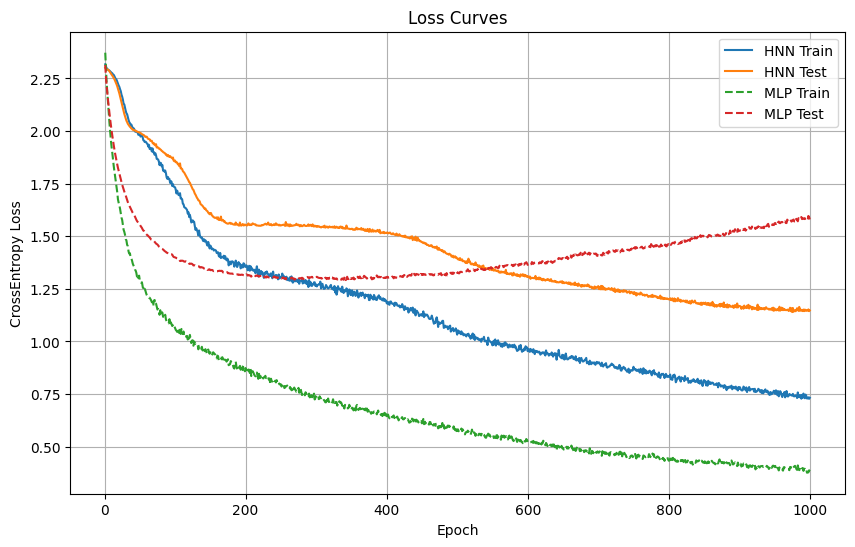

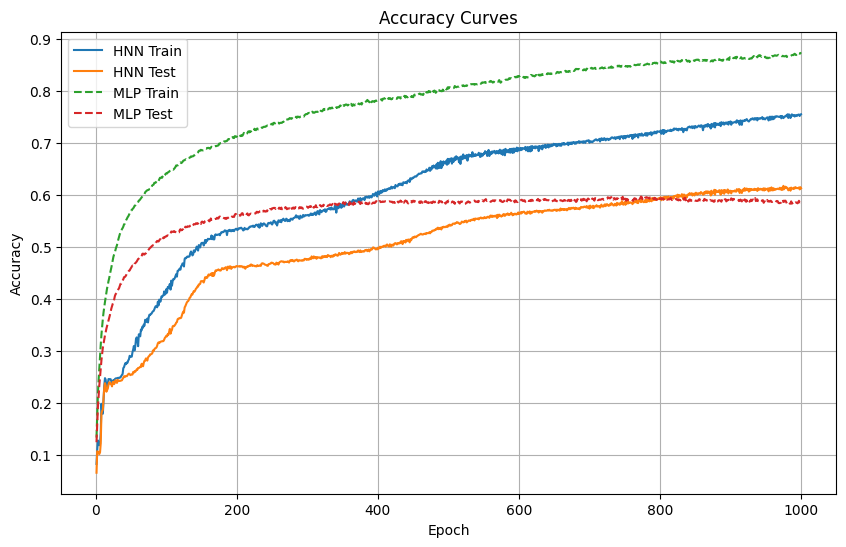

In [8]:
# --- Run training
results = train_models(num_epochs=1000)
plot_metrics(results)